In [4]:
import geatpy as ea
import numpy as np

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   20   | 9.18566E+00 | 9.18566E+00 | 9.18566E+00 | 9.18566E+00 | 0.00000E+00 
 1 |   40   | 5.78235E+00 | 9.18566E+00 | 8.33483E+00 | 5.78235E+00 | 1.47368E+00 
 2 |   60   | 5.78235E+00 | 1.01857E+01 | 8.44530E+00 | 5.78235E+00 | 1.56014E+00 
 3 |   80   | 5.18566E+00 | 9.18566E+00 | 7.10178E+00 | 5.18566E+00 | 1.70646E+00 
 4 |  100   | 2.18566E+00 | 5.78235E+00 | 5.31974E+00 | 2.18566E+00 | 1.00074E+00 
 5 |  120   | 2.18566E+00 | 5.71252E+00 | 4.47875E+00 | 2.18566E+00 | 1.38039E+00 
 6 |  140   | 2.18566E+00 | 5.18566E+00 | 2.88560E+00 | 2.18566E+00 | 1.09847E+00 
 7 |  160   | 2.02037E+00 | 2.18566E+00 | 2.15260E+00 | 2.02037E+00 | 6.61145E-02 
 8 |  180   | 2.00000E+00 | 2.18565E+00 | 2.02762E+00 | 2.00000E+00 | 3.65244E-02 
 9 |  200   | 2.00000E+00 | 2.02037E+00 | 2.01625E+00 | 2.00000E+00 | 8.12936E-03 
 10|

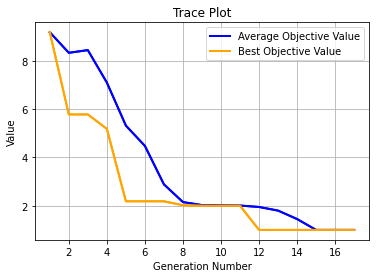

Execution time: 0.023999452590942383 s
Evaluation number: 340
The best objective value is: 1.0
The best variables are: 
1.0	1.0	2.0	1.0	1.0	


In [1]:
# 构建问题
r = 1  # 目标函数需要用到的额外数据
@ea.Problem.single
def evalVars(Vars):  # 定义目标函数（含约束）
    f = np.sum((Vars - r) ** 2)  # 计算目标函数值
    x1 = Vars[0]
    x2 = Vars[1]
    CV = np.array([(x1 - 0.5)**2 - 0.25,
                    (x2 - 1)**2 - 1])  # 计算违反约束程度
    return f, CV

problem = ea.Problem(name='soea quick start demo',
                        M=1,  # 目标维数
                        maxormins=[1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                        Dim=5,  # 决策变量维数
                        varTypes=[0, 0, 1, 1, 1],  # 决策变量的类型列表，0：实数；1：整数
                        lb=[-1, 1, 2, 1, 0],  # 决策变量下界
                        ub=[1, 4, 5, 2, 1],  # 决策变量上界
                        evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                    ea.Population(Encoding='RI', NIND=20),
                                    MAXGEN=50,  # 最大进化代数。
                                    logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                    trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                    maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, seed=1, verbose=True, drawing=1, outputMsg=True, drawLog=False, saveFlag=True, dirName='result')

In [20]:
import linear_model as model
import src.project1.submit.AI as ai
from experiment.评估函数.simulator import Simulator
from experiment.评估函数.greedy_ai import GreedyAI
import experiment.评估函数.greedys as greedys
chessboard_size = 8
time_out = 5
def greedy_fun(Vars):
    PVT, PVT_max = model.get_PVT_and_max(Vars)
    return lambda a, p : model.value_of_positions(a.reversi_env.updated_chessboard(a.chessboard, a.color, p), a.color, PVT, PVT_max)
def evalWinRate(Vars, diff=0.01, at_least_times=8):
    wins = 0
    cnts = 0
    prev_prob = np.ones(at_least_times)*100  # 不合法
    prob = -1 # 不合法
    while np.absolute(prob-prev_prob).sum()>at_least_times*diff:
        for i_color in [ai.COLOR_BLACK, ai.COLOR_WHITE]:
            agents = {i_color: GreedyAI(chessboard_size, i_color, greedy_fun(Vars)),
                  -i_color: GreedyAI(chessboard_size, -i_color, greedys.random_baseline)}
            simulator = Simulator(chessboard_size, time_out, agents)
            winner = simulator.quick_run(no_print=True)
            if winner != i_color:
                # print("loss")
                pass
            else:
                # print("win")
                wins += 1
            cnts += 1
            prev_prob = np.append(prev_prob[1:], prob)
            prob = wins/cnts
    # print(cnts)
    return prob
# evalWinRate(np.array([1, 8, 3, 7, 3, 2, 5, 6, 6, 4]))
# 实验结果: diff为0.001时，338才收敛，估算出0.7603
# diff为 0.01时，50次收敛, 估算出0.66
evalWinRate(np.array([9, 10, 18, 5, 19,15, 18, 13, 8, 3]))

0.8076923076923077

In [21]:
def evalBetterThanNeighbour(Vars):
    cnt = 0
    for neighbour in model.neighbours(Vars):
        for i_color in [ai.COLOR_BLACK, ai.COLOR_WHITE]:
            agents = {i_color: GreedyAI(chessboard_size, i_color, greedy_fun(Vars)),
                  -i_color: GreedyAI(chessboard_size, -i_color, greedy_fun(neighbour))}
            simulator = Simulator(chessboard_size, time_out, agents)
            winner = simulator.quick_run(no_print=True)
            if winner != i_color:
                cnt+=1
    # 一般有40次对决
    return (cnt/40)-0.5 # 违反约束的程度，被很多邻居打败就违反了
# evalBetterThanNeighbour(np.array([1, 8, 3, 7, 3, 2, 5, 6, 6, 4]))
evalBetterThanNeighbour(np.array([9, 10, 18, 5, 19,15, 18, 13, 8, 3]))

-0.375

64
10
36
10
46
64
68
34
54
62
52
50
40
56
42
42
52
40
46
58
gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   20   | 1.00000E+00 | 1.00000E+00 | 7.16671E-01 | 5.00000E-01 | 1.30862E-01 
58
48
32
38
56
48
52
50
34
52
36
40
42
66
46
38
40
42
42
48
 1 |   40   | 1.00000E+00 | 1.00000E+00 | 8.18398E-01 | 7.50000E-01 | 7.15595E-02 
42
56
34
10
10
48
68
34
46
10
36
36
56
40
50
38
50
54
42
34
 2 |   60   | 1.00000E+00 | 1.00000E+00 | 8.84260E-01 | 8.05556E-01 | 7.13390E-02 
52
56
46
36
38
48
34
38
52
50
44
26
66
30
44
56
10
52
38
10
 3 |   80   | 1.00000E+00 | 1.00000E+00 | 9.21276E-01 | 8.33333E-01 | 6.44144E-02 
48
10
44
42
10
44
42
30
46
32
28
10
34
36
54
44
36
54
10
48
 4 |  100   | 1.00000E+00 | 1.00000E+00 | 9.55114E-01 | 8.66667E-01 | 5.31016E-02 
48
52
38
38
36
46
10
10
30
26
42
48
44
60
10
34
10
32
38
10
 5 |  120   | 1.00000E+00 | 1.00000E+00 | 9.88456E-01 | 9.2

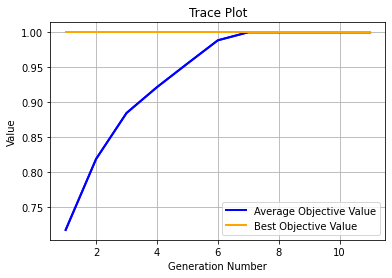

Execution time: 832.7836029529572 s
Evaluation number: 220
The best objective value is: 1.0
The best variables are: 
9	10	18	5	19	15	18	13	8	3	


In [19]:
# 构建问题
@ea.Problem.single
def evalVars(Vars):  # 定义目标函数（含约束）
    f = evalWinRate(Vars)  # 计算目标函数值
    CV = np.array(evalBetterThanNeighbour(Vars))
    return f, CV
dim = 10
varTypes = np.ones(dim) # 整数
lb = np.ones(dim)*1
ub = np.ones(dim)*20
problem = ea.Problem(name='演化计算求解最优评估函数',
                        M=1,  # 目标维数
                        maxormins=[-1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                        Dim=dim,  # 决策变量维数
                        varTypes=varTypes,  # 决策变量的类型列表，0：实数；1：整数
                        lb=lb,  # 决策变量下界
                        ub=ub,  # 决策变量上界
                        evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                    ea.Population(Encoding='RI', NIND=20),
                                    MAXGEN=50,  # 最大进化代数。
                                    logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                    trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                    maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, seed=1, verbose=True, drawing=1, outputMsg=True, drawLog=False, saveFlag=True, dirName='result')
# 第一次实验：Execution time: 832.7836029529572 s
# Evaluation number: 220
# The best objective value is: 1.0
# The best variables are:
# 9	10	18	5	19	15	18	13	8	3